# Projet de CMV 2021 : équipe 4

Réalisé par Ronan GUGUEN avec la participation de Charles CORNILLOU et Yann BOUCHET

# Analyse modale

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.integrate import odeint
import scipy.fftpack
from scipy import signal
plt.rcParams['figure.figsize'] = [12, 3]
from scipy import optimize
import functools
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 

## Paramètres relatifs à notre étude

In [2]:
# Définission des variables propres à notre problèmes
rho=7200;       #masse volumique km/m3
e=0.0005;        #épaisseur de la lame m
b=0.013;        #largeur de la lame m
S=e*b;          #section de la poutre m2
long=0.265;        #longueur de la lame m
E=203000000000; #module d'Young 
I=b*e**3/12;
m=rho*S*long
w1=1.87**2*(E*I/(m*long**3))**0.5
w2=(((2*2-1)*np.pi/2)**2)*(E*I/(m*long**3))**0.5
w3=(((2*3-1)*np.pi/2)**2)*(E*I/(m*long**3))**0.5
w4=(((2*4-1)*np.pi/2)**2)*(E*I/(m*long**3))**0.5
w5=(((2*5-1)*np.pi/2)**2)*(E*I/(m*long**3))**0.5


print('I=',I)
print('m=',m)
print('w1=',w1)
print('f1=',w1/(2*np.pi))
print('w2=',w2)
print('w3=',w3)
print('w4=',w4)
print('w5=',w5)

I= 1.3541666666666668e-13
m= 0.012402
w1= 38.16388840447355
f1= 6.073971487179433
w2= 242.35482346044188
w3= 673.2078429456719
w4= 1319.4873721735169
w5= 2181.193411143977


In [3]:
# Définission du degré de liberté
elm=3;

deg=2        #nb de degré de liberté par noeud

noeud=elm+1;

n=noeud*deg; #nb de degré de liberté total, soit le nb de colonne/ligne

print("elm =",elm,"; deg =",deg,"; noeud =",noeud,"; n =",n)

elm = 3 ; deg = 2 ; noeud = 4 ; n = 8


## Méthode de décuplement des matrices utilisées

In [4]:
# Adaptation de la matrice
r, c = 0, 0
A = np.zeros((n, n))
B = np.ones((4, 4))

print("A=\n",A)
print("B=\n",B)

for i in range(0,elm):
    A[r:r+B.shape[0], c:c+B.shape[1]] += B
    r+= 2
    c+= 2

print("A=\n",A)

A=
 [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
B=
 [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
A=
 [[1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 2. 2. 1. 1. 0. 0.]
 [1. 1. 2. 2. 1. 1. 0. 0.]
 [0. 0. 1. 1. 2. 2. 1. 1.]
 [0. 0. 1. 1. 2. 2. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]


## Etude sans ammortissement

### Construction des matrices du système

\begin{equation}
\left[ M \right] \left\lbrace \ddot{q} \right\rbrace + \left[ B \right] \left\lbrace \dot{q} \right\rbrace + \left[ K \right] \left\lbrace q \right\rbrace = \left\lbrace 0 \right\rbrace
\end{equation}

In [5]:
# Calcul des matrice de masse et de raideur
l=long/elm

coefd=0.5;
#mm0=np.array([[156,22*l,54,-13*l],[22*l,4*(l)**2,13*l,-3*(l)**2],[54,13*l,156,-22*l],[-13*l,-3*(l)**2,-22*l,4*(l)**2]]);
#mm0=((rho*S*l)/420)*mm0
mm0=np.array([[rho*S*l/2,0.,0.,0.],[0.,rho*S*l*l*l*coefd,0.,0.],[0.,0.,rho*S*l/2,0.],[0.,0.,0.,rho*S*l*l*l*coefd]]);
print("mm0 =\n",mm0)
bb0=np.zeros((4,4));
kk0=np.array([[12,6*l,-12,6*l],[6*l,4*(l)**2,-6*l,2*(l)**2],[-12,-6*l,12,-6*l],[6*l,2*(l)**2,-6*l,4*(l)**2]]);
print("kk0 =\n",kk0)
kk0=((E*I)/l**3)*kk0

print("mm0 =\n",mm0)
print("bb0 =\n",bb0)
print("kk0 =\n",kk0)

rm, cm = 0, 0
rb, cb = 0, 0
rk, ck = 0, 0

mm = np.zeros((n, n))
bb = np.zeros((n, n))
kk = np.zeros((n, n))

for i in range(0,elm):
    mm[rm:rm+mm0.shape[0], cm:cm+mm0.shape[1]] += mm0
    rm+= 2
    cm+= 2
    
for i in range(0,elm):
    bb[rb:rb+bb0.shape[0], cb:cb+bb0.shape[1]] += bb0
    rb+= 2
    cb+= 2
    
for i in range(0,elm):
    kk[rk:rk+kk0.shape[0], ck:ck+kk0.shape[1]] += kk0
    rk+= 2
    ck+= 2
    
print("mm =\n",mm)
print("bb =\n",bb)
print("kk =\n",kk)

# "Diagonaliser" la matrice (lumped matrix)

#md=np.zeros((mm.shape))
#for j in range(mm.shape[0]):
#    C=0
#    for i in range(mm.shape[1]):
#        C=C+mm[j,i]
#    md[j,j]=C
    
#print("md =\n",md)

#mm=md

mm0 =
 [[2.06700000e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.61283417e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.06700000e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.61283417e-05]]
kk0 =
 [[ 12.           0.53       -12.           0.53      ]
 [  0.53         0.03121111  -0.53         0.01560556]
 [-12.          -0.53        12.          -0.53      ]
 [  0.53         0.01560556  -0.53         0.03121111]]
mm0 =
 [[2.06700000e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.61283417e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.06700000e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.61283417e-05]]
bb0 =
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
kk0 =
 [[ 478.60314219   21.13830545 -478.60314219   21.13830545]
 [  21.13830545    1.24481132  -21.13830545    0.62240566]
 [-478.60314219  -21.13830545  478.60314219  -21.13830545]


### Mise en commun des matrices

\begin{equation}
\left[ \begin{array}{c c} \left[ 0 \right] & \left[ M \right] \\ \left[ M \right] & \left[ B \right] \end{array} \right] \left\lbrace \begin{array}{c} \left\lbrace \ddot{q} \right\rbrace \\ \left\lbrace \dot{q} \right\rbrace \end{array} \right\rbrace + \left[ \begin{array}{c c} \left[ -M \right] & \left[ 0 \right] \\ \left[ 0 \right] & \left[ K \right] \end{array} \right] \left\lbrace \begin{array}{c} \left\lbrace \dot{q} \right\rbrace \\ \left\lbrace q \right\rbrace \end{array} \right\rbrace = \left\lbrace \begin{array}{c} \left\lbrace 0 \right\rbrace \\ \left\lbrace 0 \right\rbrace \end{array} \right\rbrace
\end{equation}


In [6]:
#Encastrement du premier noeud, on exclu les deux premières lignes et les deux premières colonnes

mm = np.delete(mm, 0, 0)
mm = np.delete(mm, 0, 0)
mm = np.delete(mm, 0, 1)
mm = np.delete(mm, 0, 1)
print('mm=\n',mm)

kk = np.delete(kk, 0, 0)
kk = np.delete(kk, 0, 0)
kk = np.delete(kk, 0, 1)
kk = np.delete(kk, 0, 1)
print('kk=\n',kk)

bb = np.delete(bb, 0, 0)
bb = np.delete(bb, 0, 0)
bb = np.delete(bb, 0, 1)
bb = np.delete(bb, 0, 1)
print('bb=\n',bb)

mm=
 [[4.13400000e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.22566833e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.13400000e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.22566833e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.06700000e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.61283417e-05]]
kk=
 [[ 9.57206284e+02  0.00000000e+00 -4.78603142e+02  2.11383054e+01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.48962264e+00 -2.11383054e+01  6.22405660e-01
   0.00000000e+00  0.00000000e+00]
 [-4.78603142e+02 -2.11383054e+01  9.57206284e+02  0.00000000e+00
  -4.78603142e+02  2.11383054e+01]
 [ 2.11383054e+01  6.22405660e-01  0.00000000e+00  2.48962264e+00
  -2.11383054e+01  6.22405660e-01]
 [ 0.00000000e+

In [7]:
ms1=np.concatenate((np.zeros(mm.shape), mm), axis=0);
ms2=np.concatenate((mm, bb), axis=0);
ms=np.concatenate((ms1, ms2), axis=1);
ks1=np.concatenate((-mm, np.zeros(mm.shape)), axis=0);
ks2=np.concatenate((np.zeros(mm.shape), kk), axis=0);
ks=np.concatenate((ks1, ks2), axis=1);

#print("ms =\n",ms)
#print("\nks =\n",ks)

### Calcul des valeurs propres

In [8]:
print(la.det(ms))
print(np.linalg.cond(ms))
val_propres, vect_propres = la.eig(-np.dot(la.inv(ms),ks));
print("val_propres =", val_propres)
#print("vect_propres =", vect_propres)
lenn=(n-2)*2
DDL=int(lenn/2)
omegar=np.imag(val_propres);
print("\npulsations propres (desordre) :\n");
print("omegar =",omegar);
o_omegar=np.argsort(omegar);
#print("o_omegar =",o_omegar);

print("\n******************************");
print("pulsations propres (ordre) :");
print("\nomegar[o_omegar] =",omegar[o_omegar][DDL:DDL*2:1]);
print("\nfr =",omegar[o_omegar][DDL:DDL*2:1]/2/np.pi);
br=-np.real(val_propres)/np.abs(val_propres);

#print("******************************");
#print("amortissements modaux (desordre) :");
#print("br",br);

#print("******************************");
#print("amortissements modaux (ordre) :");
#print("br[o_omegar] =",br[o_omegar][DDL:DDL*2:1]);


3.5141566368792465e-43
256.3189747241011
val_propres = [ 3.55668148e-14+693.34981608j  3.55668148e-14-693.34981608j
 -4.04794767e-15+538.97003226j -4.04794767e-15-538.97003226j
 -3.47461082e-15+327.81307834j -3.47461082e-15-327.81307834j
  1.39345433e-14+186.06466265j  1.39345433e-14-186.06466265j
 -2.03935558e-14 +29.9257569j  -2.03935558e-14 -29.9257569j
 -1.99783391e-14+109.45132008j -1.99783391e-14-109.45132008j]

pulsations propres (desordre) :

omegar = [ 693.34981608 -693.34981608  538.97003226 -538.97003226  327.81307834
 -327.81307834  186.06466265 -186.06466265   29.9257569   -29.9257569
  109.45132008 -109.45132008]

******************************
pulsations propres (ordre) :

omegar[o_omegar] = [ 29.9257569  109.45132008 186.06466265 327.81307834 538.97003226
 693.34981608]

fr = [  4.76283214  17.41971862  29.6131108   52.17307183  85.77974481
 110.35005052]


In [9]:
vps=np.concatenate((np.zeros((2,lenn)),vect_propres[:,o_omegar]), axis=0)

print("******************************");
print("modes propres :");
#print("vps =",vps);

******************************
modes propres :


### Tracé des courbes

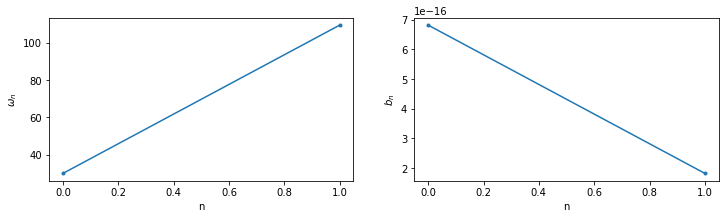

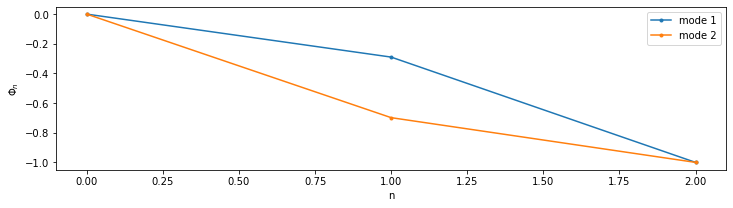

In [10]:
plt.figure();
plt.subplot(1,2,1);
plt.plot(range(0,2),omegar[o_omegar][DDL:DDL+2:1],'.-');
plt.xlabel("n");
plt.ylabel("$\omega_{n}$");
plt.subplot(1,2,2);
plt.plot(range(0,2),br[o_omegar][DDL:DDL+2:1],'.-');
plt.xlabel("n");
plt.ylabel("$b_{n}$");

plt.figure();
for i in range(0,2):
    plt.plot(np.real(vps)[:DDL:2,DDL+i]/np.max(np.abs(np.real(vps)[:DDL:2,DDL+i])),'.-');
plt.xlabel("n");
plt.ylabel("$\Phi_{n}$");
plt.legend(['mode 1','mode 2','mode 3'])

## Calcul des matrices avec prise en compte de l'amortissement

### Matrice d'amortissement

In [11]:
#On calcul deus coefficients, A et B, de sorte à ce que [B] = A*[K] + B*[M]
#Pour ce faire, il nous fait prendre 2 omega voisins et un facteyr ksi qu'il faudras déterminer expérimentalement

w_1=omegar[o_omegar][DDL] # 
#w_2=omegar[o_omegar][DDL+1]
#w_3=omegar[o_omegar][DDL+2]
#w_4=omegar[o_omegar][DDL+3]
#w_5=omegar[o_omegar][DDL+4]
print("w_1 =",w_1)

#print(w_5)
ksi=0.01
#A=ksi*2/(w_1+w_5)
#B=ksi*2*w_1*w_5/(w_1+w_5)

print("ksi =",ksi)
#print('w_1,w_2=',w_1,w_2)
#print("A =",A)
#print("B =",B)

w_1 = 29.925756897788137
ksi = 0.01


In [12]:
# Calcul des matrice de masse, de raideur et d'amortissement

l=long/elm # l est la longueur d'un élément, c'est donc la longueur total divisé par le nombre d'élément

# mm, kk et bb sont les matrices assemblées


#bb= A*kk + B*mm # matrice d'amortissement lié à l'inertie et à la raideur

bb= 2*ksi*w_1*mm # matrice d'amortissement lié à l'inertie # A PRIVILEGIER

#bb= 2*ksi/w_1*kk # A ne pas faire

print('bb=\n',bb)
print('mm=\n',mm)
print('kk=\n',kk)


bb=
 [[2.47426158e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93061133e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.47426158e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.93061133e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.23713079e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.65305664e-06]]
mm=
 [[4.13400000e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.22566833e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.13400000e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.22566833e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000

### Mise en commun des matrices

\begin{equation}
\left[ \begin{array}{c c} \left[ 0 \right] & \left[ M \right] \\ \left[ M \right] & \left[ B \right] \end{array} \right] \left\lbrace \begin{array}{c} \left\lbrace \ddot{q} \right\rbrace \\ \left\lbrace \dot{q} \right\rbrace \end{array} \right\rbrace + \left[ \begin{array}{c c} \left[ -M \right] & \left[ 0 \right] \\ \left[ 0 \right] & \left[ K \right] \end{array} \right] \left\lbrace \begin{array}{c} \left\lbrace \dot{q} \right\rbrace \\ \left\lbrace q \right\rbrace \end{array} \right\rbrace = \left\lbrace \begin{array}{c} \left\lbrace 0 \right\rbrace \\ \left\lbrace 0 \right\rbrace \end{array} \right\rbrace
\end{equation}

In [13]:
ms1_b=np.concatenate((np.zeros(mm.shape), mm), axis=0);
ms2_b=np.concatenate((mm, bb), axis=0);
ms_b=np.concatenate((ms1_b, ms2_b), axis=1);
ks1_b=np.concatenate((-mm, np.zeros(mm.shape)), axis=0);
ks2_b=np.concatenate((np.zeros(mm.shape), kk), axis=0);
ks_b=np.concatenate((ks1_b, ks2_b), axis=1);

print("ms_b =\n",ms_b)
print("\nks_b =\n",ks_b)

ms_b =
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.13400000e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.22566833e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.13400000e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.22566833e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.06700000e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

### Calcul des valeurs propres

725298.911244594 (sans amortissement)


121075384563.68018 ($\xi=0.01$/4 éléments)


3026789069043.6553 ($\xi=0.05$/4 éléments)


136104490963463.84 ($\xi=0.01$/8 éléments)

In [14]:
print(la.det(ms_b))
print(np.linalg.cond(ms_b))
val_propres_b, vect_propres_b = la.eig(-np.dot(la.inv(ms_b),ks_b));
print("val_propres_b =", val_propres_b)
#print("vect_propres_b =", vect_propres_b)
lenn=(n-2)*2
DDL=int(lenn/2)
omegar_b=np.imag(val_propres_b);
print("\npulsations propres (desordre) :\n");
print("omegar_b =",omegar_b);
o_omegar_b=np.argsort(omegar_b);
#print("o_omegar_b =",o_omegar_b);

print("\n******************************");
print("\npulsations propres (ordre) :");
print("\nomegar_b[o_omegar_b] =",omegar_b[o_omegar_b][DDL:DDL*2:1]);
print("\nfr =",omegar_b[o_omegar_b][DDL:DDL*2:1]/2/np.pi);
br_b=-np.real(val_propres_b)/np.abs(val_propres_b);

#print("******************************");
#print("amortissements modaux (desordre) :");
#print("br_b",br_b);

#print("******************************");
#print("amortissements modaux (ordre) :");
#print("br_b[o_omegar_b] =",br_b[o_omegar_b][DDL:DDL*2:1]);


3.5141566368792465e-43
462.3611861739383
val_propres_b = [-0.29925757+693.3497515j  -0.29925757-693.3497515j
 -0.29925757+538.96994918j -0.29925757-538.96994918j
 -0.29925757+327.81294175j -0.29925757-327.81294175j
 -0.29925757+186.06442199j -0.29925757-186.06442199j
 -0.29925757 +29.92426057j -0.29925757 -29.92426057j
 -0.29925757+109.45091097j -0.29925757-109.45091097j]

pulsations propres (desordre) :

omegar_b = [ 693.3497515  -693.3497515   538.96994918 -538.96994918  327.81294175
 -327.81294175  186.06442199 -186.06442199   29.92426057  -29.92426057
  109.45091097 -109.45091097]

******************************

pulsations propres (ordre) :

omegar_b[o_omegar_b] = [ 29.92426057 109.45091097 186.06442199 327.81294175 538.96994918
 693.3497515 ]

fr = [  4.76259399  17.41965351  29.61307249  52.17305009  85.77973159
 110.35004024]


In [15]:
vps_b=np.concatenate((np.zeros((2,lenn)),vect_propres_b[:,o_omegar_b]), axis=0)

print("******************************");
print("modes propres :");
#print("vps_b =",vps_b);

******************************
modes propres :


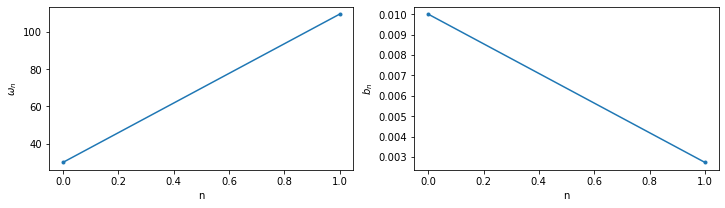

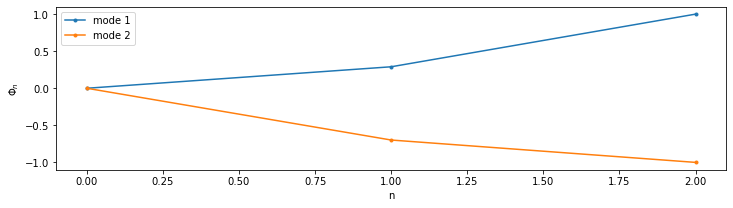

In [16]:
plt.figure();
plt.subplot(1,2,1);
plt.plot(range(0,2),omegar_b[o_omegar_b][DDL:DDL+2:1],'.-');
plt.xlabel("n");
plt.ylabel("$\omega_{n}$");
plt.subplot(1,2,2);
plt.plot(range(0,2),br_b[o_omegar_b][DDL:DDL+2:1],'.-');
plt.xlabel("n");
plt.ylabel("$b_{n}$");

plt.figure();
for i in range(0,2):
    plt.plot(np.real(vps_b)[:DDL:2,DDL+i]/np.max(np.abs(np.real(vps_b)[:DDL:2,DDL+i])),'.-');
plt.xlabel("n");
plt.ylabel("$\Phi_{n}$");
plt.legend(['mode 1','mode 2','mode 3'])

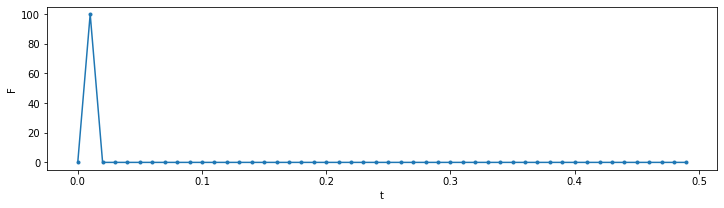

In [17]:
hh=0.01;

tt=np.arange(0,20,hh);

def force(t):
    tmax=hh;
    Fmax=1/tmax;
    if t<=tmax :
        f=t*Fmax/tmax;
    elif (t>tmax)and(t<=2*tmax) :
        f=-Fmax/tmax*t+2*Fmax;
    else :
        f=0
    return f

ff=np.zeros(tt.shape)


for ii in range(len(tt)):
    ff[ii]=force(tt[ii])
    
plt.plot(tt[0:50],ff[0:50],'.-');
plt.xlabel('t');
plt.ylabel('F');

In [18]:
print("kk",kk)
print("bb",bb)
#bb=np.abs(bb)
#print("bb",bb)
print("mm",mm)
#mm=np.abs(mm)
#print("mm",mm)

print("kk.shape",kk.shape)
print("bb.shape",bb.shape)
print("mm.shape",mm.shape)
print("DDL",DDL)

def cauchy(U,t):
    Udot = np.zeros(U.shape)
    #print("test",len(U))
    for i in range(DDL):
        #print("i",i,2*i,2*i+1)
        Udot[2*i]=U[2*i+1]
        Udot[2*i+1]=(-np.vdot(kk[i,:],U[0::2])-np.vdot(bb[i,:],U[1::2]))/mm[i,i]
    #print(Udot,Udot[len(U)-3])
    #print(mm,mm[DDL-2,DDL-2])
    #print(t,force(t))
    Udot[len(U)-3]=Udot[len(U)-3]+force(t)/mm[DDL-2,DDL-2]
    return Udot

kk [[ 9.57206284e+02  0.00000000e+00 -4.78603142e+02  2.11383054e+01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.48962264e+00 -2.11383054e+01  6.22405660e-01
   0.00000000e+00  0.00000000e+00]
 [-4.78603142e+02 -2.11383054e+01  9.57206284e+02  0.00000000e+00
  -4.78603142e+02  2.11383054e+01]
 [ 2.11383054e+01  6.22405660e-01  0.00000000e+00  2.48962264e+00
  -2.11383054e+01  6.22405660e-01]
 [ 0.00000000e+00  0.00000000e+00 -4.78603142e+02 -2.11383054e+01
   4.78603142e+02 -2.11383054e+01]
 [ 0.00000000e+00  0.00000000e+00  2.11383054e+01  6.22405660e-01
  -2.11383054e+01  1.24481132e+00]]
bb [[2.47426158e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93061133e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.47426158e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.93061133e-05
  0.00000000e+00 0.00000000e+00]
 [0.000

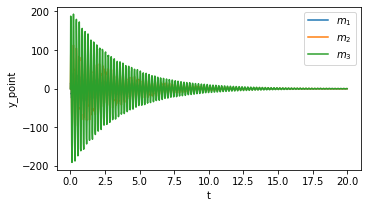

In [20]:
y0=np.zeros(2*DDL);
yode=odeint(cauchy,y0,tt);

#ydot=np.zeros(yode.shape);
#for ii in range(len(tt)):
#    ydot[ii,:]=cauchy(yode[ii,:],tt[ii]);

plt.figure();
plt.subplot(1,2,1);
plt.plot(tt,yode[:,1::4]);
plt.xlabel("t");
plt.ylabel("y_point");
plt.legend(['$m_{1}$','$m_{2}$','$m_{3}$'])

plt.subplot(1,2,2);
plt.plot(tt,ydot[2:50,1:2*DDL:2]);
plt.xlabel("t");
plt.ylabel("$\ddot{y}$");
plt.legend(['$m_{1}$','$m_{2}$','$m_{3}$'])

Cette version de la tâche est incomplette et à dû etre abrégé pour etre rendu avec les autres rapports. 